# T 201: Experimentation and Uplift Testing

This notebook serves as the solution of the second task **Experimentation and Uplift Testing** of **Quantium Data Analytics Virtual Experience Program.**

In the previous task we conducted analysis on the client's transaction dataset and identified customer purchasing behaviours to generate insights and provided commercial recommendations.

We now extend our analysis from Task 1 to help us identify benchmark stores that allow you to test the impact of the trial store layouts on customer sales.

Category Manager for Chips, has asked us to test the impact of the new trial layouts with a data driven recommendation to whether or not the trial layout should be rolled out to all their stores.

They new trial layouts were rolled in three stores, **store number 77, 86, and 88** during trial period. The trial period was for three months, i.e. **February, March, and April 2019.**

We will complete this task in two phases.
- **Phase 1:** We will find control store corrosponding to the trial stores   
- **Phase 2:** Assessment of trial stores during the trial period


**What is Control Store?**

Store that have similar performance to trial store in terms of measure like monthly sales, number of customers, etc.


### Sequence of Analysis
1. We will be considering *monthly sales and number of customers* to find the potential control store.


2. Then we will define driving metrics to rank the stores on how similar they are to the trial store.
    - Correlation Score
    - Absolute Distance Score 


3. We will select the store having higest score as control store for the corrosponding trial store. 
    - Only pre-trial period will considered to select the control store
    - We will also visualise the performance to cross check that we have selected right control store


4. Once we get control store for each trial store, we will assess the trail store performance during the trial period.
    - We will use statistical tests and visualizations to test the impact of the new trial layouts for these stores
    
    
5. Finally, we will make conclusion on whether or not the trial layout should be rolled out to all their stores.

# Importing Libraries

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
sns.set(font_scale=1)


import warnings
warnings.filterwarnings("ignore")

# Loading Dataset

In [2]:
#loading dataset
df = pd.read_csv("C:/Users/amitm/Jupyter Notebools/Quantium/Task 2/QVI_data.csv")

In [3]:
#checking first 5 rows
df.head()

,LYLTY_CARD_NBR,DATE,STORE_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PACK_SIZE,BRAND,LIFESTAGE,PREMIUM_CUSTOMER
0,1000,2018-10-17,1,1,5,Natural Chip Compny SeaSalt175g,2,6.0,175,NATURAL,YOUNG SINGLES/COUPLES,Premium
1,1002,2018-09-16,1,2,58,Red Rock Deli Chikn&Garlic Aioli 150g,1,2.7,150,RRD,YOUNG SINGLES/COUPLES,Mainstream
2,1003,2019-03-07,1,3,52,Grain Waves Sour Cream&Chives 210G,1,3.6,210,GRNWVES,YOUNG FAMILIES,Budget
3,1003,2019-03-08,1,4,106,Natural ChipCo Hony Soy Chckn175g,1,3.0,175,NATURAL,YOUNG FAMILIES,Budget
4,1004,2018-11-02,1,5,96,WW Original Stacked Chips 160g,1,1.9,160,WOOLWORTHS,OLDER SINGLES/COUPLES,Mainstream


### Checking data type of variables

In [4]:
#checking data types
df.dtypes

LYLTY_CARD_NBR        int64
DATE                 object
STORE_NBR             int64
TXN_ID                int64
PROD_NBR              int64
PROD_NAME            object
PROD_QTY              int64
TOT_SALES           float64
PACK_SIZE             int64
BRAND                object
LIFESTAGE            object
PREMIUM_CUSTOMER     object
dtype: object

### Creating Year-Month column

Since we are interested in analyzing numbers on monthly basis, therefore, we are extracting year and month from date column and storing it in `yyyymm` format.

In [5]:
#created new column MonthID in yyyymm format from the DATE column
df["MonthID"] = df["DATE"].str.slice(0,7)
df["MonthID"] = df["MonthID"].str.replace(pat="-",repl="")
df.head()

,LYLTY_CARD_NBR,DATE,STORE_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PACK_SIZE,BRAND,LIFESTAGE,PREMIUM_CUSTOMER,MonthID
0,1000,2018-10-17,1,1,5,Natural Chip Compny SeaSalt175g,2,6.0,175,NATURAL,YOUNG SINGLES/COUPLES,Premium,201810
1,1002,2018-09-16,1,2,58,Red Rock Deli Chikn&Garlic Aioli 150g,1,2.7,150,RRD,YOUNG SINGLES/COUPLES,Mainstream,201809
2,1003,2019-03-07,1,3,52,Grain Waves Sour Cream&Chives 210G,1,3.6,210,GRNWVES,YOUNG FAMILIES,Budget,201903
3,1003,2019-03-08,1,4,106,Natural ChipCo Hony Soy Chckn175g,1,3.0,175,NATURAL,YOUNG FAMILIES,Budget,201903
4,1004,2018-11-02,1,5,96,WW Original Stacked Chips 160g,1,1.9,160,WOOLWORTHS,OLDER SINGLES/COUPLES,Mainstream,201811


> # Phase 1: Finding Control Stores

### Potential Control Store

To find how similar each potential control store is to the trial store, we are going to use two parameters:
- Monthly Total Sales 
- Monthly Unique Number of Customers

Therfore, we are grouping the data by Store number and Months.

In [6]:
#group data by STR_NBR and MonthID,and taking sum of TOT_SALES and unique count of LYLTY_CARD_NBR.
measureOverTime = df.groupby(["STORE_NBR","MonthID"]).agg({"TOT_SALES":"sum","LYLTY_CARD_NBR":pd.Series.nunique}).reset_index()

#renaming columns to reflect the true meaning of the features
measureOverTime.rename(columns={"TOT_SALES":"totSales","LYLTY_CARD_NBR":"nCustomers"},inplace=True)

measureOverTime

,STORE_NBR,MonthID,totSales,nCustomers
0,1,201807,206.9,49
1,1,201808,176.1,42
2,1,201809,278.8,59
3,1,201810,188.1,44
4,1,201811,192.6,46
...,...,...,...,...
3164,272,201902,395.5,45
3165,272,201903,442.3,50
3166,272,201904,445.1,54
3167,272,201905,314.6,34


### Stores with full observations

We are interested in stores, who are operated or had transactions for all 12 months. We will consider only these stores for analysis and leave other stores.

*For this we simply count MonthID for each store and consider those having equal to 12.*

In [7]:
#saving store numbers having count of MonthIDs = 12
storesWithFullObs = measureOverTime.groupby("STORE_NBR")["MonthID"].count().reset_index()

storesWithFullObs = storesWithFullObs[storesWithFullObs["MonthID"] == 12]["STORE_NBR"].unique()

storesWithFullObs

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  12,  13,  14,
        15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,
        28,  29,  30,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,
        42,  43,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  55,
        56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,  67,  68,
        69,  70,  71,  72,  73,  74,  75,  77,  78,  79,  80,  81,  82,
        83,  84,  86,  87,  88,  89,  90,  91,  93,  94,  95,  96,  97,
        98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110,
       111, 112, 113, 114, 115, 116, 118, 119, 120, 121, 122, 123, 124,
       125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137,
       138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150,
       151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163,
       164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176,
       177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 18

#### Changing data type of MonthID from object to integer for ease

In [8]:
measureOverTime.dtypes

STORE_NBR       int64
MonthID        object
totSales      float64
nCustomers      int64
dtype: object

In [9]:
measureOverTime["MonthID"] = measureOverTime["MonthID"].astype(int)

measureOverTime.dtypes

STORE_NBR       int64
MonthID         int32
totSales      float64
nCustomers      int64
dtype: object

### Data for pre-trial period

We know that trail period is from February 2019 to April 2019, and to find how similar each potential control store is to the trial , we will perform the analysis on pre-trial period.

*Therfore, we are slicing the data for stores having full observations and for time period July 2018 to January 2019.*

In [10]:
preTrialMeasures = measureOverTime[(measureOverTime["STORE_NBR"].isin(storesWithFullObs)) & \
                                   (measureOverTime["MonthID"] < 201902)]

preTrialMeasures

,STORE_NBR,MonthID,totSales,nCustomers
0,1,201807,206.9,49
1,1,201808,176.1,42
2,1,201809,278.8,59
3,1,201810,188.1,44
4,1,201811,192.6,46
...,...,...,...,...
3159,272,201809,304.7,32
3160,272,201810,430.6,44
3161,272,201811,376.2,41
3162,272,201812,403.9,47


## Defining Driving Metrics


We will be using two main metrics for finding the similarity between control strores and trial stores.

- **Correlation Score**
    - We will calculate how correlated the performance of each store is to the trial store
    - Correlation value lies between -1 to 1. *Value near to 1 means similarity value near to -1 means dis-similarity*
    
- **Absolute Difference Score**
    - We will calculate the absolute difference between the trial store's performance and each control store's performance
    - We will standardize the distance so that the measure ranges from 0 to 1
    - We will take (1 - standardized distance) so that it has similar effect as correlation score. *Value near to 1 means similarity value near to 0 means dis-similarity*
    
    
We will be using these metrics to calculate score for both `totSales` and `nCustomer` i.e. we will be having total 4 scores for each control store to the trail store. Then we will combine all these scores to get one score for each store and we sort them in descending order. ***Store with higest score other than trial store itself becomes the control store of the respective trial store.***

*Let us define the functions to calculate all 4 scores and to store them into a sangle dataframe. It will reduces our time of re-write the code again.*

In [11]:
def corrSales(data, trialStore):
    """
    It calculates the the correlation score of each store to the trial store obased on total sales.
    
    Parameters:
                data: (dataframe) It takes dataframe contaning store number, months, sales and number of customers
                trialStore: (integer) It takes the trial store number from which we need to compare all stores
    
    Return: It returns a dataframe with store number and correlation score corrosponding to that store and the trail store
    """
    
    df = data[["STORE_NBR","MonthID","totSales"]]
    storeNBR = df["STORE_NBR"].unique()
    corr = list()
    
    ts = df[df["STORE_NBR"] == trialStore].iloc[:,-1]
    for n in storeNBR:
        cs = df[df["STORE_NBR"] == n].iloc[:,-1]
        corr.append(np.corrcoef(ts,cs)[0,1])
    
    corrSalesDf = pd.DataFrame({"STORE_NBR":storeNBR,"corrSales":corr})
    
    return corrSalesDf

In [12]:
def corrCust(data, trialStore):
    """
    It calculates the the correlation score of each store to the trial store based on number of customers.
    
    Parameters:
                data: (dataframe) It takes dataframe contaning store number, months, sales and number of customers
                trialStore: (integer) It takes the trial store number from which we need to compare all stores
    
    Return: It returns a dataframe with store number and correlation score corrosponding to that store and the trail store
    """
    
    df = data[["STORE_NBR","MonthID","nCustomers"]]
    storeNBR = df["STORE_NBR"].unique()
    corr = list()
    
    ts = df[df["STORE_NBR"] == trialStore].iloc[:,-1]
    for n in storeNBR:
        cs = df[df["STORE_NBR"] == n].iloc[:,-1]
        corr.append(np.corrcoef(ts,cs)[0,1])
    
    corrCustDf = pd.DataFrame({"STORE_NBR":storeNBR,"corrCust":corr})
    
    return corrCustDf

In [13]:
def magDistSales(data, trialStore):
    """
    It calculates the the absoulte distance of each store to the trial store based on monthly sales.
    
    Parameters:
                data: (dataframe) It takes dataframe contaning store number, months, sales and number of customers
                trialStore: (integer) It takes the trial store number from which we need to compare all stores
    
    Return: It returns a dataframe with store number and absolute distance corrosponding to that store and the trail store
    """
    df = data[["STORE_NBR","MonthID","totSales"]]
    storeNBR = df["STORE_NBR"].unique()
    dist = list()
    
    ts = np.array(df[df["STORE_NBR"] == trialStore].iloc[:,-1])
    for n in storeNBR:
        cs = np.array(df[df["STORE_NBR"] == n].iloc[:,-1])
        d = sum(np.abs(ts - cs))
        dist.append(d)
    
    magDistSalesDf = pd.DataFrame({"STORE_NBR":storeNBR,"distSales":dist})
    
    return magDistSalesDf

In [14]:
def magDistCust(data, trialStore):
    """
    It calculates the the absoulte distance of each store to the trial store based on number of customers.
    
    Parameters:
                data: (dataframe) It takes dataframe contaning store number, months, sales and number of customers
                trialStore: (integer) It takes the trial store number from which we need to compare all stores
    
    Return: It returns a dataframe with store number and absolute distance corrosponding to that store and the trail store
    """
    df = data[["STORE_NBR","MonthID","nCustomers"]]
    storeNBR = df["STORE_NBR"].unique()
    dist = list()
    
    ts = np.array(df[df["STORE_NBR"] == trialStore].iloc[:,-1])
    for n in storeNBR:
        cs = np.array(df[df["STORE_NBR"] == n].iloc[:,-1])
        d = sum(np.abs(ts - cs))
        dist.append(d)
    
    magDistCustDf = pd.DataFrame({"STORE_NBR":storeNBR,"distCust":dist})
    
    return magDistCustDf

In [15]:
def stdMagDis(data, colList):
    """
    It standarizes the absolute distance so that the measure ranges from 0 to 1.
    Parameters:
                data: (dataframe) It takes dataframe contaning absolute distance score
                colList: (list) It takes the list of columns which needs to be standardized.
                        To standardize, it uses MinMaxScalar from sckit-learn library
    
    Return: It returns the dataframe with (1 - standardized distance) and all other given columns
    """
    df = data.copy()
    
    from sklearn.preprocessing import MinMaxScaler
    minMaxScalar = MinMaxScaler()
    
    df[colList] = minMaxScalar.fit_transform(df[colList])
    
    for col in colList:
        df.loc[:, col] = 1 - df.loc[:, col]
        
    return df

In [16]:
def controlStores(data, trialStore):
    """
    It returns a dataframe with all 4 scores correlation score for sales and number of customers, absolute difference score 
    for sales and number of customers of each store to the given trial store.
    
    It merge all 4 dataframes returned from different functions into one single dataframe.
    
    Parameters:
                data: (dataframe) It takes dataframe contaning store number, months, sales and number of customers
                trailStore: (integer) It takes the trial store number from which we need to compare all stores

    """
    controlStoresDf = corrSales(data, trialStore)
    
    #merging corrSales and corrCust -> controlStoresDf
    controlStoresDf = controlStoresDf.merge(right=corrCust(data, trialStore), how="inner", on="STORE_NBR")
    
    #merging controlStoresDf and magDistSales -> controlStoresDf
    controlStoresDf = controlStoresDf.merge(right=magDistSales(data, trialStore), how="inner", on="STORE_NBR")
    
    #merging controlStoresDf and magDistCust -> controlStoresDf
    controlStoresDf = controlStoresDf.merge(right=magDistCust(data, trialStore), how="inner", on="STORE_NBR")
    
    #Standardising the magnitude distance so that the measure ranges from 0 to 1
    controlStoresDf = stdMagDis(controlStoresDf, ["distSales","distCust"])
    
    #creating a column to show the compared trial store number
    controlStoresDf.loc[:, "trialStore"] = trialStore
    
    #returning final dataframe
    return controlStoresDf

### Let's see all four score corrosponding to Trial Store (77)

In [17]:
controlStores77 = controlStores(preTrialMeasures, 77)

controlStores77

,STORE_NBR,corrSales,corrCust,distSales,distCust,trialStore
0,1,0.075218,0.322168,0.950903,0.938744,77
1,2,-0.263079,-0.572051,0.933198,0.921899,77
2,3,0.806644,0.834207,0.317676,0.318530,77
3,4,-0.263300,-0.295639,0.130226,0.157734,77
4,5,-0.110652,0.370659,0.526858,0.460949,77
...,...,...,...,...,...,...
255,268,0.344757,0.369517,0.958964,0.937213,77
256,269,-0.315730,-0.474293,0.418570,0.315467,77
257,270,0.315430,-0.131259,0.414653,0.333844,77
258,271,0.355487,0.019629,0.523884,0.459418,77


### Let's see all four score corrosponding to Trial Store (86)

In [18]:
controlStores86 = controlStores(preTrialMeasures, 86)

controlStores86

,STORE_NBR,corrSales,corrCust,distSales,distCust,trialStore
0,1,0.445632,0.485831,0.212664,0.433681,86
1,2,-0.403835,-0.086161,0.169679,0.366617,86
2,3,-0.261284,-0.353786,0.766059,0.912072,86
3,4,-0.039035,-0.169608,0.499755,0.773472,86
4,5,0.235159,-0.253229,0.924119,0.922504,86
...,...,...,...,...,...,...
255,268,-0.452182,-0.034273,0.239638,0.414307,86
256,269,0.697055,-0.098587,0.899881,0.918033,86
257,270,-0.730679,-0.767267,0.836892,0.891207,86
258,271,0.527637,0.267393,0.919228,0.932936,86


### Let's see all four score corrosponding to Trial Store (88)

In [19]:
controlStores88 = controlStores(preTrialMeasures, 88)

controlStores88

,STORE_NBR,corrSales,corrCust,distSales,distCust,trialStore
0,1,0.813636,0.305334,0.137831,0.340749,88
1,2,-0.067927,-0.452379,0.109972,0.288056,88
2,3,-0.507847,0.522884,0.799738,0.840749,88
3,4,-0.745566,-0.361503,0.897187,0.923888,88
4,5,0.190330,-0.025320,0.607131,0.731850,88
...,...,...,...,...,...,...
255,268,-0.021429,0.672672,0.155314,0.325527,88
256,269,-0.172578,-0.274781,0.706839,0.843091,88
257,270,-0.723272,-0.103032,0.710445,0.829040,88
258,271,-0.103037,-0.018831,0.609869,0.733021,88


### Let's concatenate scores corrosponding to all three trial stores into a single dataframe

In [20]:
controlStoresAll = pd.concat([controlStores77,controlStores86,controlStores88],axis=0).reset_index(drop=True)

controlStoresAll

,STORE_NBR,corrSales,corrCust,distSales,distCust,trialStore
0,1,0.075218,0.322168,0.950903,0.938744,77
1,2,-0.263079,-0.572051,0.933198,0.921899,77
2,3,0.806644,0.834207,0.317676,0.318530,77
3,4,-0.263300,-0.295639,0.130226,0.157734,77
4,5,-0.110652,0.370659,0.526858,0.460949,77
...,...,...,...,...,...,...
775,268,-0.021429,0.672672,0.155314,0.325527,88
776,269,-0.172578,-0.274781,0.706839,0.843091,88
777,270,-0.723272,-0.103032,0.710445,0.829040,88
778,271,-0.103037,-0.018831,0.609869,0.733021,88


### Combining all 4 scores to get a single score

We'll now combine all 4 scores to get a single score for each store to a trail store. This will be the final score to decide the control store.

*We will be assigning equal weightage to all four drivers and combine them i.e. we will be taking simple average of all scores.*

In [21]:
#taking average of correlation and absoulte difference difference scores for sales
controlStoresAll["scoreNSales"] = (0.5 * controlStoresAll["corrSales"]) + (0.5 * controlStoresAll["distSales"])

#taking average of correlation and absoulte difference difference scores for number of customers
controlStoresAll["scoreNCust"] = (0.5 * controlStoresAll["corrCust"]) + (0.5 * controlStoresAll["distCust"])

#we are taking average of sales and number of customers scores
controlStoresAll["finalControlScore"] = (0.5 * controlStoresAll["scoreNSales"]) + (0.5 * controlStoresAll["scoreNCust"])

In [22]:
controlStoresAll

,STORE_NBR,corrSales,corrCust,distSales,distCust,trialStore,scoreNSales,scoreNCust,finalControlScore
0,1,0.075218,0.322168,0.950903,0.938744,77,0.513060,0.630456,0.571758
1,2,-0.263079,-0.572051,0.933198,0.921899,77,0.335060,0.174924,0.254992
2,3,0.806644,0.834207,0.317676,0.318530,77,0.562160,0.576369,0.569264
3,4,-0.263300,-0.295639,0.130226,0.157734,77,-0.066537,-0.068953,-0.067745
4,5,-0.110652,0.370659,0.526858,0.460949,77,0.208103,0.415804,0.311954
...,...,...,...,...,...,...,...,...,...
775,268,-0.021429,0.672672,0.155314,0.325527,88,0.066942,0.499099,0.283021
776,269,-0.172578,-0.274781,0.706839,0.843091,88,0.267131,0.284155,0.275643
777,270,-0.723272,-0.103032,0.710445,0.829040,88,-0.006413,0.363004,0.178295
778,271,-0.103037,-0.018831,0.609869,0.733021,88,0.253416,0.357095,0.305256


### Control Store for Trial Store  (77)

*The store with the Highest score (other than trial store itself) will be selected as the control store since it is most similar to the trial store.*

In [23]:
controlStoresAll[controlStoresAll["trialStore"] == 77].sort_values("finalControlScore",ascending=False)

,STORE_NBR,corrSales,corrCust,distSales,distCust,trialStore,scoreNSales,scoreNCust,finalControlScore
72,77,1.000000,1.000000,1.000000,1.000000,77,1.000000,1.000000,1.000000
221,233,0.903774,0.990358,0.984567,0.992343,77,0.944171,0.991350,0.967761
38,41,0.783232,0.844219,0.962834,0.973966,77,0.873033,0.909093,0.891063
15,17,0.842668,0.747308,0.872450,0.961715,77,0.857559,0.854511,0.856035
241,254,0.577108,0.916208,0.917168,0.934150,77,0.747138,0.925179,0.836159
...,...,...,...,...,...,...,...,...,...
3,4,-0.263300,-0.295639,0.130226,0.157734,77,-0.066537,-0.068953,-0.067745
130,138,-0.585174,-0.534877,0.458558,0.358346,77,-0.063308,-0.088266,-0.075787
235,247,-0.631050,-0.621034,0.498955,0.402757,77,-0.066047,-0.109139,-0.087593
95,102,-0.550834,-0.652527,0.462890,0.372129,77,-0.043972,-0.140199,-0.092086


> ### *Store 233 is the Control Store corrosponding to Trial Store 77 because it has the highest score among all other stores*

### Control Store for Trial Store  (86)

*The store with the Highest score (other than trial store itself) will be selected as the control store since it is most similar to the trial store.*

In [24]:
controlStoresAll[controlStoresAll["trialStore"] == 86].sort_values("finalControlScore",ascending=False)

,STORE_NBR,corrSales,corrCust,distSales,distCust,trialStore,scoreNSales,scoreNCust,finalControlScore
340,86,1.000000,1.000000,1.000000,1.000000,86,1.000000,1.000000,1.000000
407,155,0.877882,0.942876,0.962197,0.985097,86,0.920039,0.963986,0.942013
362,109,0.788300,0.770778,0.963195,0.965723,86,0.875747,0.868250,0.871999
367,114,0.734415,0.855339,0.919935,0.934426,86,0.827175,0.894883,0.861029
390,138,0.759864,0.749701,0.923802,0.926975,86,0.841833,0.838338,0.840085
...,...,...,...,...,...,...,...,...,...
361,108,-0.840413,-0.697245,0.329577,0.327869,86,-0.255418,-0.184688,-0.220053
308,52,-0.601629,-0.594459,0.024254,0.020864,86,-0.288688,-0.286798,-0.287743
372,120,-0.872693,-0.815097,0.160064,0.357675,86,-0.356315,-0.228711,-0.292513
299,42,-0.745720,-0.664952,0.009233,0.019374,86,-0.368243,-0.322789,-0.345516


> ### *Store 155 is the Control Store corrosponding to Trial Store 86 because it has the highest score among all other stores*

### Control Store for Trial Store  (88)

*The store with the Highest (other than trial store itself) score will be selected as the control store since it is most similar to the trial store.*

In [25]:
controlStoresAll[controlStoresAll["trialStore"] == 88].sort_values("finalControlScore",ascending=False)

,STORE_NBR,corrSales,corrCust,distSales,distCust,trialStore,scoreNSales,scoreNCust,finalControlScore
602,88,1.000000,1.000000,1.000000,1.000000,88,1.000000,1.000000,1.000000
745,237,0.308479,0.947326,0.955903,0.987119,88,0.632191,0.967223,0.799707
690,178,0.731857,0.939466,0.693901,0.818501,88,0.712879,0.878984,0.795931
585,69,0.450029,0.815792,0.706057,0.867681,88,0.578043,0.841737,0.709890
626,113,0.495763,0.862632,0.680855,0.781030,88,0.588309,0.821831,0.705070
...,...,...,...,...,...,...,...,...,...
604,90,-0.662427,-0.503735,0.175513,0.310304,88,-0.243457,-0.096715,-0.170086
765,258,0.087493,-0.825850,0.008248,0.001171,88,0.047871,-0.412339,-0.182234
653,141,-0.690590,-0.547399,0.195038,0.286885,88,-0.247776,-0.130257,-0.189016
747,239,-0.642329,-0.660672,0.247620,0.291569,88,-0.197355,-0.184552,-0.190953


> ### *Store 237 is the Control Store corrosponding to Trial Store 88 because it has the highest score among all other stores*

## Assessment of Control Stores prior Trial Period
### (July 2018 - January 2019)

Now that we have found a control store, let's check visually if the drivers are indeed similar in the period before the trial for control store, trial store and other stores(taking all other stores together).

*Let us define a function to reduce our efforts*

In [26]:
def controlStoresPriorTrialPeriodViz(data,controlStore,trialStore,savfig=False):
    """
    It create two line plots, one for sales and another for number of customers for the given control and trial store to check
    visually if the drivers are indeed similar in the period before the trial.
    
    Parameters:
                data: (dataframe) It takes dataframe with store number, months, sales and number of customers for all stores
                controlStore: (integer) It takes control store number
                trialStore: (integer) It takes corrosponding trial store number
                savfig: (boolean) It asks for saving the figure on the local system or not, by default it is False. 
    
    It creates a single line for stores other than control and trial store by aggregating values by mean
    """
    df = data.copy()
    
    df["storeType"] = df["STORE_NBR"].apply(lambda x: "Control" if x==controlStore else "Others")
    df.loc[df["STORE_NBR"]==trialStore,"storeType"] = "Trial"
    df = df[df["MonthID"] < 201902]
    df["MonthID"] = df["MonthID"].astype(str)
    
    plt.figure(figsize=(15,4))
    plt.subplot(1,2,1)
    sns.lineplot(data=df, x="MonthID", y="totSales", hue="storeType", estimator="mean", err_style=None, style="storeType",\
                dashes=[(2,1),(1,0),(5,1)])
    plt.xlabel("Time Period (yyyymm)",size=13)
    plt.ylabel("Sales",size=13)
    
    plt.subplot(1,2,2)
    sns.lineplot(data=df, x="MonthID", y="nCustomers", hue="storeType", estimator="mean", err_style=None, style="storeType",\
                dashes=[(2,1),(1,0),(5,1)])
    plt.xlabel("Time Period (yyyymm)",size=13)
    plt.ylabel("Number od Customers",size=13)
    
    plt.suptitle(f"Comparing stores performance (prior trial period)\nTrial Store: {trialStore}  Control Store: {controlStore}")
    
    if savfig==True:
        path="C:/Users/amitm/Jupyter Notebools/Quantium/Task 2/"+"Stores Performance ("+str(trialStore)+").jpeg"
        plt.savefig(path,dpi=500)

### Visualizing stores performance in the period before the trial for Control Store (233) and Trial Store (77)

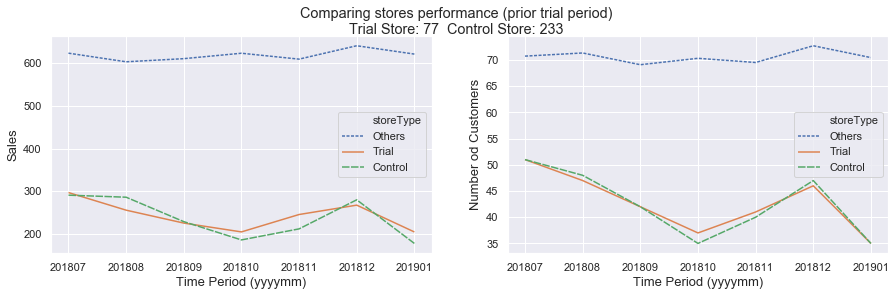

In [27]:
controlStoresPriorTrialPeriodViz(measureOverTime, controlStore=233, trialStore= 77, savfig=True)

### Insights:

- We can see that lines are almost over lapping each other in both charts for control store and trial store and others store line is way far from trial store

- This shows that the choosen control store (233) is correct and have very similar performance to the trial store (77) in terms of our choosen drivers

**Note:** *Measures are aggregated by mean for other stores*

### Let's visualise stores performance in the period before the trial for Control Store (155) and Trial Store (86)

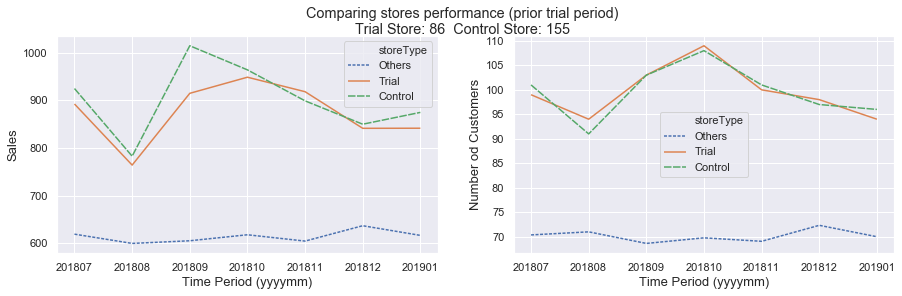

In [28]:
controlStoresPriorTrialPeriodViz(measureOverTime, controlStore=155, trialStore=86, savfig=True)

### Insights:

- We can see that lines are almost over lapping each other in both charts for control store and trial store and others store line is way far from trial store

- This shows that the choosen control store (155) is correct and have very similar performance to the trial store (86) in terms of our choosen drivers

**Note:** *Measures are aggregated by mean for other stores*

### Let's visualise stores performance in the period before the trial for Control Store (237) and Trial Store (88)

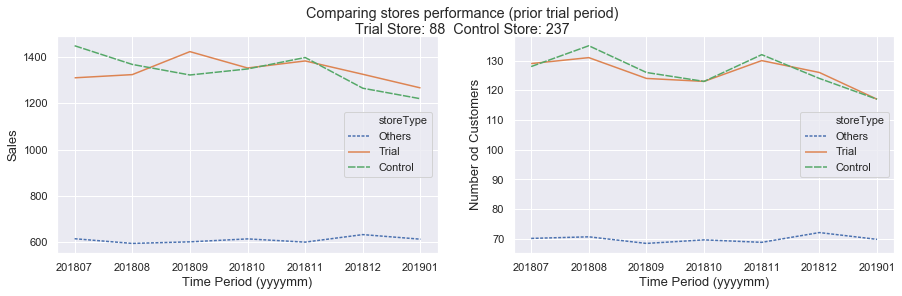

In [29]:
controlStoresPriorTrialPeriodViz(measureOverTime, controlStore=237, trialStore=88, savfig=True)

### Insights:

- We can see that lines are almost over lapping each other in both charts for control store and trial store and others store line is way far from trial store

- This shows that the choosen control store (237) is correct and have very similar performance to the trial store (88) in terms of our choosen drivers

**Note:** *Measures are aggregated by mean for other stores*

> # Phase 2: Assessment of Trial Stores during the Trial Period

### (February 2019 - April 2020)

Our goal is to see if there has been an uplift in overall chip sales in trail stores. We now have control stores to compare compare the results and make conclusion.

To do that, ***first we need to scale the control store's sales to  a level similar to control for any differences between the two stores outside of the trial period.***

---
## Assessment of sales of Trial Store (77)

### Calculating Scaling Factor for Control Store's Sale

\begin{equation*}
Scaling Factor = \frac{\sum Trial \,Store's \,Sales \,(prior \,trial \,period)}{\sum Control \,Store's \,Sales \,(prior \,trial \,period)}
\end{equation*}

In [30]:
scalingFactorForControlSales = preTrialMeasures[preTrialMeasures["STORE_NBR"]==77]["totSales"].sum()/ preTrialMeasures[\
                                              preTrialMeasures["STORE_NBR"]==233]["totSales"].sum()

scalingFactorForControlSales

1.023617303289553

### Creating a dataframe with control store's data only for all months

In [31]:
scaledControlSales = measureOverTime[measureOverTime["STORE_NBR"]==233][["STORE_NBR","MonthID","totSales"]]

scaledControlSales

,STORE_NBR,MonthID,totSales
2699,233,201807,290.7
2700,233,201808,285.9
2701,233,201809,228.6
2702,233,201810,185.7
2703,233,201811,211.6
2704,233,201812,279.8
2705,233,201901,177.5
2706,233,201902,244.0
2707,233,201903,199.1
2708,233,201904,158.6


### Scaling control store's sales

\begin{equation*}
controlSales = Control \,Store's \,Sales \,*\, Scaling \,Factor
\end{equation*}

In [32]:
scaledControlSales["controlSales"] = scaledControlSales["totSales"] * scalingFactorForControlSales

scaledControlSales

,STORE_NBR,MonthID,totSales,controlSales
2699,233,201807,290.7,297.565550
2700,233,201808,285.9,292.652187
2701,233,201809,228.6,233.998916
2702,233,201810,185.7,190.085733
2703,233,201811,211.6,216.597421
2704,233,201812,279.8,286.408121
2705,233,201901,177.5,181.692071
2706,233,201902,244.0,249.762622
2707,233,201903,199.1,203.802205
2708,233,201904,158.6,162.345704


### Merging trial store's sales in the same dataframe

In [33]:
trialSales = measureOverTime[measureOverTime["STORE_NBR"]==77][["MonthID","totSales"]]

scaledControlSales = scaledControlSales.merge(trialSales,on="MonthID")

scaledControlSales.rename(columns={"totSales_x":"totSales","totSales_y":"trialSales"},inplace=True)

scaledControlSales

,STORE_NBR,MonthID,totSales,controlSales,trialSales
0,233,201807,290.7,297.565550,296.8
1,233,201808,285.9,292.652187,255.5
2,233,201809,228.6,233.998916,225.2
3,233,201810,185.7,190.085733,204.5
4,233,201811,211.6,216.597421,245.3
5,233,201812,279.8,286.408121,267.3
6,233,201901,177.5,181.692071,204.4
7,233,201902,244.0,249.762622,235.0
8,233,201903,199.1,203.802205,278.5
9,233,201904,158.6,162.345704,263.5


### Calculating Percentage Difference in Sales

Now that we have comparable sales figures for the control store, we can calculate the percentage difference between the scaled control sales and the trial store's sales during the trial period.

In [34]:
scaledControlSales["percentageDiff"] = np.abs(scaledControlSales["controlSales"] - scaledControlSales["trialSales"]) /\
                                scaledControlSales["controlSales"]

scaledControlSales

,STORE_NBR,MonthID,totSales,controlSales,trialSales,percentageDiff
0,233,201807,290.7,297.565550,296.8,0.002573
1,233,201808,285.9,292.652187,255.5,0.126950
2,233,201809,228.6,233.998916,225.2,0.037602
3,233,201810,185.7,190.085733,204.5,0.075830
4,233,201811,211.6,216.597421,245.3,0.132516
5,233,201812,279.8,286.408121,267.3,0.066716
6,233,201901,177.5,181.692071,204.4,0.124980
7,233,201902,244.0,249.762622,235.0,0.059107
8,233,201903,199.1,203.802205,278.5,0.366521
9,233,201904,158.6,162.345704,263.5,0.623080


### Check if the difference is significant!

We need to check and confirm this statistically, and we will do hypothesis testing. Our hyothesis will be,

**Null Hypothesis:** There is no difference in sales in trial and pre-trial period

**Alternate Hypothesis:** There is a difference in sales in trial and pre-trial period

#### Let's calculate the standard deviation based on the scaled percentage difference in the pre-trial period

In [35]:
stdDev = scaledControlSales[scaledControlSales["MonthID"] < 201902]["percentageDiff"].std()

stdDev

0.049940762641425544

#### Let's calculate the t-value

*Our focus will be for trial period only*

We are testing with a null hypothesis of there being 0 difference between trial and control stores, that's why we have subtracted zero, 

\begin{equation*}
t-value = \frac{Percentage \,Difference - \,0}{Standard \,Deviation}
\end{equation*}

In [36]:
scaledControlSales["tValue"] = (scaledControlSales["percentageDiff"] - 0) / stdDev

scaledControlSales

,STORE_NBR,MonthID,totSales,controlSales,trialSales,percentageDiff,tValue
0,233,201807,290.7,297.565550,296.8,0.002573,0.051515
1,233,201808,285.9,292.652187,255.5,0.126950,2.542011
2,233,201809,228.6,233.998916,225.2,0.037602,0.752940
3,233,201810,185.7,190.085733,204.5,0.075830,1.518406
4,233,201811,211.6,216.597421,245.3,0.132516,2.653459
5,233,201812,279.8,286.408121,267.3,0.066716,1.335911
6,233,201901,177.5,181.692071,204.4,0.124980,2.502571
7,233,201902,244.0,249.762622,235.0,0.059107,1.183534
8,233,201903,199.1,203.802205,278.5,0.366521,7.339116
9,233,201904,158.6,162.345704,263.5,0.623080,12.476373


**The 95th percentile of the t-distribution with the appropriate degrees of freedom to check whether the hypothesis is statistically significant.**

Since there are 7 months in the pre-trial period

Hence, *degrees of freedom = 6 (7 - 1)*

In [37]:
#0.95 taken because we are interested to know 95 percentile of t-distribution
degreesOfFreedom = 6
stats.t.ppf(0.95,df=degreesOfFreedom)

1.9431802803927816

#### Comparing t-value and 95th percentile of the t-distribution for trial period

In [38]:
scaledControlSales[scaledControlSales["MonthID"].isin([201902,201903,201904])]

,STORE_NBR,MonthID,totSales,controlSales,trialSales,percentageDiff,tValue
7,233,201902,244.0,249.762622,235.0,0.059107,1.183534
8,233,201903,199.1,203.802205,278.5,0.366521,7.339116
9,233,201904,158.6,162.345704,263.5,0.623080,12.476373


### Observation:

We can observe that the t-value is much larger than the 95th percentile value of the t-distribution for March and April - i.e. the increase in sales in the trial store in March and April is statistically greater than in the control store.

### Visualizing the Sales of Trial and Control Store

Let's create a more visual version of this by plotting the sales of the control store, trial store, other stores and the 5% and 95% confidence level of control store's sales.

*Let's define a function for this which we can use for other stores also*

In [39]:
def controlStoreViz(data,controlStore,trialStore,stdDev,on,savfig=False):
    """
    It plots a line plot sales/ number of customers of Trail Store, Control Store, and Others Store along with 5% and 95% 
    percentile confidence level of control store's sales/ number of customers over the whole type period.
    
    Parameters:
                data: (dataframe) It takes dataframe with store number, months, sales and number of customers for all month
                controlStore: (integer) It takes control store's number
                trialStore: (integer) It takes trial store's number
                stdDev: (float) It takes the standard deviation which is used in hypothesis testing
                on: (string) It takes only two values "totSales", "nCustomers" to plot using corrosponding measure
                savefig: (boolean) It asks to save the chart on the local system ot not, by default it is False
                
    It creates a single line for stores other than control and trial store by aggregating values by mean
    """
    df = data[["STORE_NBR","MonthID",on]]
    
    df["storeType"] = df["STORE_NBR"].apply(lambda x: "Control" if x==controlStore else "Others")
    df.loc[df["STORE_NBR"]==trialStore,"storeType"] = "Trial"
    
    
    Controls95 = pd.DataFrame(columns=["STORE_NBR","MonthID",on,"storeType"])
    Controls95[on] = df[df["STORE_NBR"]==controlStore][on] * (1 + 2 * stdDev)
    Controls95["STORE_NBR"] = df[df["STORE_NBR"]==controlStore]["STORE_NBR"]
    Controls95["MonthID"] = df[df["STORE_NBR"]==controlStore]["MonthID"]
    Controls95["storeType"] = ["Control 95th % confidence interval"] * len(df[df["STORE_NBR"]==controlStore])
    
    
    Controls05 = Controls95.copy()
    Controls05[on] = df[df["STORE_NBR"]==controlStore][on] * (1 - 2 * stdDev)
    Controls05.loc[:,"storeType"] = "Control 5th % confidence interval"
    
    df = df.append(Controls95,ignore_index=True)
    df = df.append(Controls05,ignore_index=True)
    
    df["MonthID"] = df["MonthID"].astype(str)
    
    name=""
    if on == "totSales":
        name="Sales"
    else:
        name="Number of customers"
    
    plt.figure(figsize=(15,6))
    sns.lineplot(data=df, x="MonthID", y=on, hue="storeType", estimator="mean", err_style=None, style="storeType",\
                dashes=[(1,0),(1,0),(1,0),(3,1),(3,1)])
    plt.xlabel("Time Period (yyyymm)",size=15)
    plt.ylabel(name,size=15)
    
    areaMax = df.groupby(["MonthID","storeType"])[on].mean().max()
    plt.fill_between(["201902","201904"],[areaMax],color="skyblue", alpha=0.5)
    
    ytext = df[df["storeType"]=="Others"].groupby(["MonthID"])[on].mean().min() - 20
    plt.text("201902",y=ytext,s="        Trial Period",color="blue",size=15)
    plt.title(f"\nTrial Store: {trialStore}  Control Store: {controlStore}",size=15)
    
    plt.suptitle(name+" over the period",size=20)
    
    if savfig==True:
        path="C:/Users/amitm/Jupyter Notebools/Quantium/Task 2/"+name+" All ("+str(trialStore)+").jpeg"
        plt.savefig(path,dpi=500)


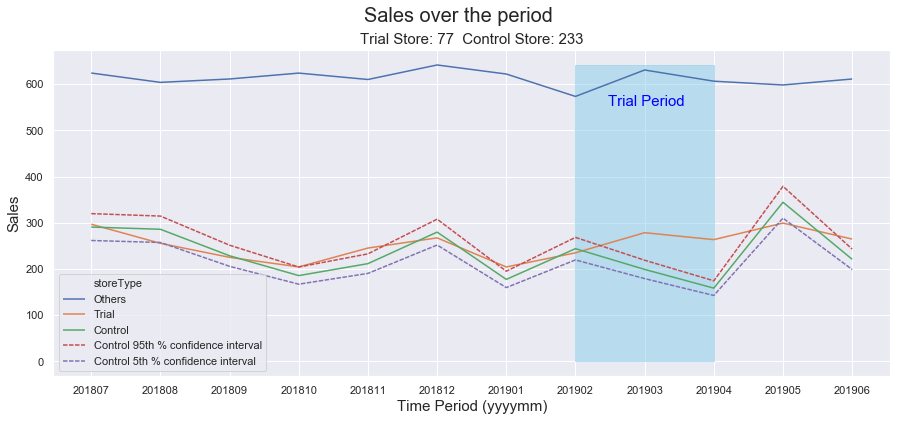

In [40]:
controlStoreViz(measureOverTime, controlStore=233, trialStore=77, stdDev=stdDev, on="totSales", savfig=True)

### Observation:

The results show that the trial in store 77 is **significantly different** to its control store in the trial period as the trial store performance **lies outside** the 5% and 95% confidence interval of the control store in **two of the three trial months**.

---
## Assessment of Number of Customers of Trial Store (77)

Let's now see if there has been an uplift in number of customers in trail stores during trial period.

To do this, we need perform the same calculations we did above on sales, but now on number of customers.

*Let's define a function for all this, it will help in assessing other trial stores also and it will save our lot of time*

In [41]:
def trialPeriodUplift(data,controlStore,trialStore,scalingFactorForControl,on):
    """
    This function returns the dataframe like we got above before hypothesis testing and it also returns standard deviation which
    is calculated on percentage difference of pre-trial period
    
    Parameters:
                data: (dataframe) It takes dataframe with store number, months, sales and number of customers for all month
                controlStore: (integer) It takes control store's number
                trialStore: (integer) It takes trial store's number
                scalingFactorForControl: (float) It takes the scaling factor through which we will get control sales/no. of cust
                on: (string) It takes only two values "totSales", "nCustomers" to plot using corrosponding measure
    
    Return: Dataframe, standard deviation (float)
    """
    
    contname=""
    trialname=""
    if on=="totSales":
        contname="controlSales"
        trialname="trialSales"
    else:
        contname="controlCust"
        trialname="trialCust"
        
        
    scaledControl = data[data["STORE_NBR"]==controlStore][["STORE_NBR","MonthID",on]]
    
    scaledControl[contname] = scaledControl[on] * scalingFactorForControl
    
    
    trial = data[data["STORE_NBR"]==trialStore][["MonthID",on]]
    trial.rename(columns={on:trialname},inplace=True)

    scaledControl = scaledControl.merge(trial,on="MonthID")
    
    scaledControl["percentageDiff"] = np.abs(scaledControl[contname] - scaledControl[trialname]) / scaledControl[contname]
    
    stdDev = scaledControl[scaledControl["MonthID"] < 201902]["percentageDiff"].std()
    
    scaledControl["tValue"] = (scaledControl["percentageDiff"] - 0) / stdDev
    
    return scaledControl, stdDev

### Calculating Scaling Factor for Control Store's Number of Customers

In [42]:
scalingFactor= preTrialMeasures[preTrialMeasures["STORE_NBR"]==77]["nCustomers"].sum()/ preTrialMeasures[\
                                              preTrialMeasures["STORE_NBR"]==233]["nCustomers"].sum()
scalingFactor

1.0033557046979866

In [43]:
scaledControlCust, stdDev = trialPeriodUplift(measureOverTime,controlStore=233, trialStore=77, \
                                               scalingFactorForControl=scalingFactor, on="nCustomers")

scaledControlCust

,STORE_NBR,MonthID,nCustomers,controlCust,trialCust,percentageDiff,tValue
0,233,201807,51,51.171141,51,0.003344,0.183352
1,233,201808,48,48.161074,47,0.024108,1.321664
2,233,201809,42,42.140940,42,0.003344,0.183352
3,233,201810,35,35.117450,37,0.053607,2.938874
4,233,201811,40,40.134228,41,0.021572,1.182622
5,233,201812,47,47.157718,46,0.024550,1.345883
6,233,201901,35,35.117450,35,0.003344,0.183352
7,233,201902,45,45.151007,45,0.003344,0.183352
8,233,201903,40,40.134228,50,0.245819,13.476388
9,233,201904,30,30.100671,47,0.561427,30.778725


#### The 95th percentile of the t-distribution with the appropriate degrees of freedom to check whether the hypothesis is statistically significant.

Since there are 7 months in the pre-trial period

Hence, degrees of freedom = 6 (7 - 1)

In [44]:
degreesOfFreedom = 7
stats.t.ppf(0.95,df=degreesOfFreedom)

1.894578605061305

#### Comparing t-value and 95th percentile of the t-distribution for trial period

In [45]:
scaledControlCust[scaledControlCust["MonthID"].isin([201902,201903,201904])]

,STORE_NBR,MonthID,nCustomers,controlCust,trialCust,percentageDiff,tValue
7,233,201902,45,45.151007,45,0.003344,0.183352
8,233,201903,40,40.134228,50,0.245819,13.476388
9,233,201904,30,30.100671,47,0.561427,30.778725


### Observation:
We can observe that the **t-value is much larger** than the 95th percentile value of the t-distribution for March and April - i.e. the **increase in customers** in the trial store in March and April is statistically greater than in the control store.

### Visualizing the Number of Customers of Trial and Control Store

Let's create a more visual version of this by plotting the number of customers of the control store, trial store, other stores and the 5% and 95% confidence level of control store's number of customers.

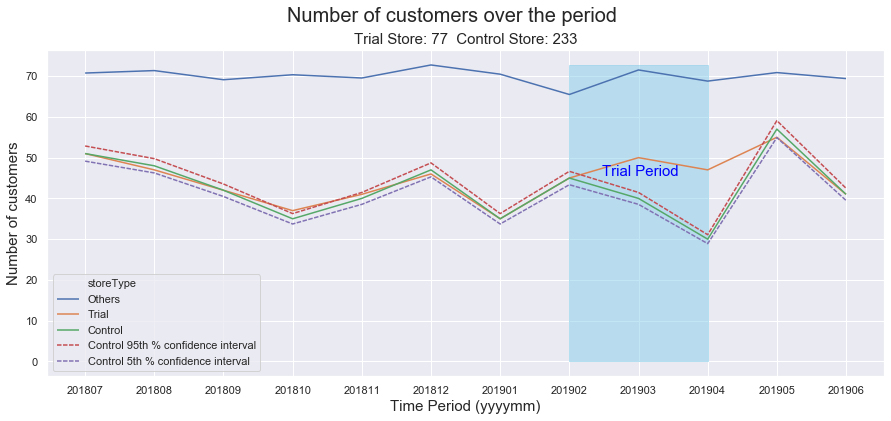

In [46]:
controlStoreViz(measureOverTime, controlStore=233, trialStore=77, stdDev=stdDev, on="nCustomers", savfig=True)

### Observation:
The results show that the trial in store 77 is **significantly different** to its control store in the trial period as the trial store performance **lies outside** the 5% and 95% confidence interval of the control store in **two of the three trial months**.

---
## Assessment of Sales of Trial Store (86)

### Calculating Scaling Factor for Control Store's Sale

In [47]:
scalingFactor= preTrialMeasures[preTrialMeasures["STORE_NBR"]==86]["totSales"].sum()/ preTrialMeasures[\
                                              preTrialMeasures["STORE_NBR"]==155]["totSales"].sum()
scalingFactor

0.9700651481287746

In [48]:
scaledControlSales, stdDev = trialPeriodUplift(measureOverTime,controlStore=155, trialStore=86, \
                                               scalingFactorForControl=scalingFactor, on="totSales")

scaledControlSales

,STORE_NBR,MonthID,totSales,controlSales,trialSales,percentageDiff,tValue
0,155,201807,924.60,896.922236,892.20,0.005265,0.203799
1,155,201808,782.70,759.269991,764.05,0.006296,0.243692
2,155,201809,1014.40,984.034086,914.60,0.070561,2.731315
3,155,201810,963.80,934.948790,948.40,0.014387,0.556907
4,155,201811,898.80,871.894555,918.00,0.052880,2.046904
5,155,201812,849.80,824.361363,841.20,0.020426,0.790676
6,155,201901,874.60,848.418979,841.40,0.008273,0.320238
7,155,201902,891.20,864.522060,913.20,0.056306,2.179542
8,155,201903,804.40,780.320405,1026.80,0.315870,12.226922
9,155,201904,844.60,819.317024,848.20,0.035253,1.364580


#### The 95th percentile of the t-distribution with the appropriate degrees of freedom to check whether the hypothesis is statistically significant.

Since there are 7 months in the pre-trial period

Hence, degrees of freedom = 6 (7 - 1)

In [49]:
degreesOfFreedom = 7
stats.t.ppf(0.95,df=degreesOfFreedom)

1.894578605061305

#### Comparing t-value and 95th percentile of the t-distribution for trial period

In [50]:
scaledControlSales[scaledControlSales["MonthID"].isin([201902,201903,201904])]

,STORE_NBR,MonthID,totSales,controlSales,trialSales,percentageDiff,tValue
7,155,201902,891.2,864.522060,913.2,0.056306,2.179542
8,155,201903,804.4,780.320405,1026.8,0.315870,12.226922
9,155,201904,844.6,819.317024,848.2,0.035253,1.364580


### Observation:
We can observe that the **t-value is larger** than the 95th percentile value of the t-distribution for **February and March** - i.e. the **increase in sales** in the trial store in February and March is statistically greater than in the control store.

### Visualizing the Sales of Trial and Control Store

Let's create a more visual version of this by plotting the sales of the control store, trial stores, other stores and the 5% and 95% confidence level of control store's sales.

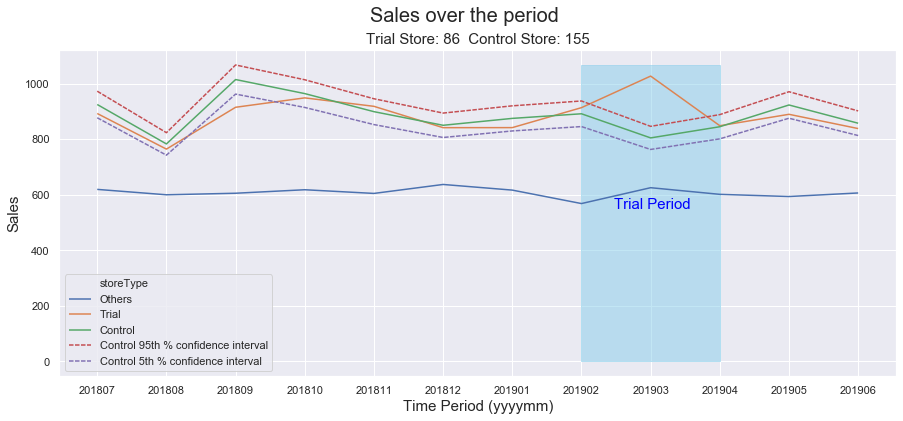

In [51]:
controlStoreViz(measureOverTime, controlStore=155, trialStore=86, stdDev=stdDev, on="totSales", savfig=True)

### Observation:

The results show that the trial in store 86 is **not significantly different** to its control store in the trial period as the trial store performance **lies inside** the 5% to 95% confidence interval of the control store in **two of the three trial months.**

---
## Assessment of Number of Customers of Trial Store (86)

### Calculating Scaling Factor for Control Store's Number of Customers

In [52]:
scalingFactor= preTrialMeasures[preTrialMeasures["STORE_NBR"]==86]["nCustomers"].sum()/ preTrialMeasures[\
                                              preTrialMeasures["STORE_NBR"]==155]["nCustomers"].sum()
scalingFactor

1.0

In [53]:
scaledControlCust, stdDev = trialPeriodUplift(measureOverTime,controlStore=155, trialStore=86, \
                                               scalingFactorForControl=scalingFactor, on="nCustomers")
scaledControlCust

,STORE_NBR,MonthID,nCustomers,controlCust,trialCust,percentageDiff,tValue
0,155,201807,101,101.0,99,0.019802,1.852826
1,155,201808,91,91.0,94,0.032967,3.084651
2,155,201809,103,103.0,103,0.000000,0.000000
3,155,201810,108,108.0,109,0.009259,0.866368
4,155,201811,101,101.0,100,0.009901,0.926413
5,155,201812,97,97.0,98,0.010309,0.964616
6,155,201901,96,96.0,94,0.020833,1.949328
7,155,201902,95,95.0,107,0.126316,11.819082
8,155,201903,94,94.0,115,0.223404,20.903430
9,155,201904,99,99.0,105,0.060606,5.670772


#### The 95th percentile of the t-distribution with the appropriate degrees of freedom to check whether the hypothesis is statistically significant.

Since there are 7 months in the pre-trial period

Hence, degrees of freedom = 6 (7 - 1)

In [54]:
degreesOfFreedom = 7
stats.t.ppf(0.95,df=degreesOfFreedom)

1.894578605061305

#### Comparing t-value and 95th percentile of the t-distribution for trial period

In [55]:
scaledControlCust[scaledControlCust["MonthID"].isin([201902,201903,201904])]

,STORE_NBR,MonthID,nCustomers,controlCust,trialCust,percentageDiff,tValue
7,155,201902,95,95.0,107,0.126316,11.819082
8,155,201903,94,94.0,115,0.223404,20.903430
9,155,201904,99,99.0,105,0.060606,5.670772


### Observation:
We can observe that the t-value is **much larger** than the 95th percentile value of the t-distribution for **all three trial months** - i.e. the **increase in number of customers** in the trial store in all three trial months is statistically greater than in the control store.

### Visualizing the Number of Customers of Trial and Control Store

Let's create a more visual version of this by plotting the number of customers of the control store, trial stores, other stores and the 5% and 95% confidence level of control store's number of customers.

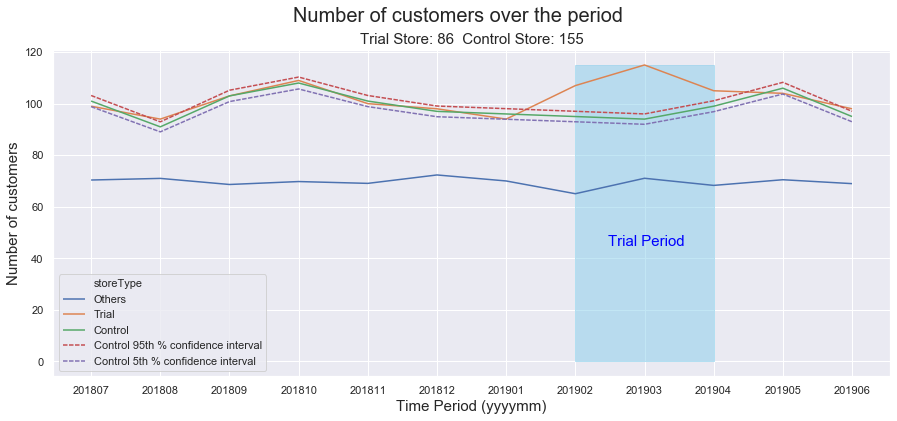

In [56]:
controlStoreViz(measureOverTime, controlStore=155, trialStore=86, stdDev=stdDev, on="nCustomers", savfig=True)

### Observation:
The results show that the trial in store 86 is **significantly different** to its control store in the trial period as the trial store performance **lies outside** the 5% and 95% confidence interval of the control store in **all three trial months.**

---
## Assessment of Sales of Trial Store (88)

### Calculating Scaling Factor for Control Store's Sale

In [57]:
scalingFactor= preTrialMeasures[preTrialMeasures["STORE_NBR"]==88]["totSales"].sum()/ preTrialMeasures[\
                                              preTrialMeasures["STORE_NBR"]==237]["totSales"].sum()
scalingFactor

1.0015583306649594

In [58]:
scaledControlSales, stdDev = trialPeriodUplift(measureOverTime,controlStore=237, trialStore=88, \
                                               scalingFactorForControl=scalingFactor, on="totSales")
scaledControlSales

,STORE_NBR,MonthID,totSales,controlSales,trialSales,percentageDiff,tValue
0,237,201807,1448.4,1450.657086,1310.00,0.096961,2.897136
1,237,201808,1367.8,1369.931485,1323.80,0.033674,1.006168
2,237,201809,1322.2,1324.260425,1423.00,0.074562,2.227870
3,237,201810,1348.3,1350.401097,1352.40,0.001480,0.044228
4,237,201811,1397.6,1399.777923,1382.80,0.012129,0.362408
5,237,201812,1265.0,1266.971288,1325.20,0.045959,1.373227
6,237,201901,1219.7,1221.600696,1266.40,0.036673,1.095756
7,237,201902,1404.8,1406.989143,1370.20,0.026147,0.781270
8,237,201903,1208.2,1210.082775,1477.20,0.220743,6.595668
9,237,201904,1204.6,1206.477165,1439.40,0.193060,5.768527


#### The 95th percentile of the t-distribution with the appropriate degrees of freedom to check whether the hypothesis is statistically significant.

Since there are 7 months in the pre-trial period

Hence, degrees of freedom = 6 (7 - 1)

In [59]:
degreesOfFreedom = 7
stats.t.ppf(0.95,df=degreesOfFreedom)

1.894578605061305

#### Comparing t-value and 95th percentile of the t-distribution for trial period

In [60]:
scaledControlSales[scaledControlSales["MonthID"].isin([201902,201903,201904])]

,STORE_NBR,MonthID,totSales,controlSales,trialSales,percentageDiff,tValue
7,237,201902,1404.8,1406.989143,1370.2,0.026147,0.781270
8,237,201903,1208.2,1210.082775,1477.2,0.220743,6.595668
9,237,201904,1204.6,1206.477165,1439.4,0.193060,5.768527


### Observation:
We can observe that the **t-value is larger** than the 95th percentile value of the t-distribution for **March and April** - i.e. the **increase in sales** in the trial store in March and April is statistically greater than in the control store.

### Visualizing the Sales of Trial and Control Store

Let's create a more visual version of this by plotting the sales of the control store, trial stores, other stores and the 5% and 95% confidence level of control store's sales.

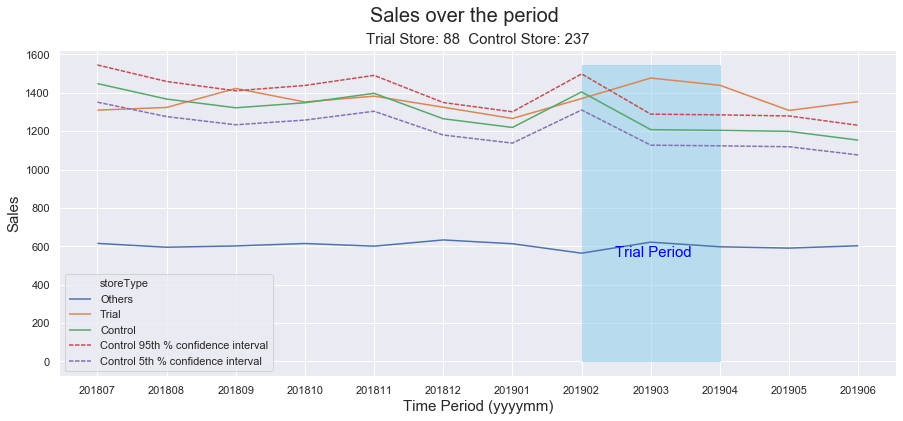

In [61]:
controlStoreViz(measureOverTime, controlStore=237, trialStore=88, stdDev=stdDev, on="totSales", savfig=True)

### Observation:

The results show that the trial in store 88 is **significantly different** to its control store in the trial period as the trial store performance **lies outside** the 5% and 95% confidence interval of the control store in **two of the three trial months.**

---
## Assessment of Number of Customers of Trial Store (88)

### Calculating Scaling Factor for Control Store's Number of Customers

In [62]:
scalingFactor= preTrialMeasures[preTrialMeasures["STORE_NBR"]==88]["nCustomers"].sum()/ preTrialMeasures[\
                                              preTrialMeasures["STORE_NBR"]==237]["nCustomers"].sum()
scalingFactor

0.9943502824858758

In [63]:
scaledControlCust, stdDev = trialPeriodUplift(measureOverTime,controlStore=237, trialStore=88, \
                                               scalingFactorForControl=scalingFactor, on="nCustomers")
scaledControlCust

,STORE_NBR,MonthID,nCustomers,controlCust,trialCust,percentageDiff,tValue
0,237,201807,128,127.276836,129,0.013539,1.827026
1,237,201808,135,134.237288,131,0.024116,3.254435
2,237,201809,126,125.288136,124,0.010281,1.387456
3,237,201810,123,122.305085,123,0.005682,0.766752
4,237,201811,132,131.254237,130,0.009556,1.289537
5,237,201812,124,123.299435,126,0.021902,2.955705
6,237,201901,117,116.338983,117,0.005682,0.766752
7,237,201902,126,125.288136,124,0.010281,1.387456
8,237,201903,119,118.327684,134,0.132448,17.873693
9,237,201904,120,119.322034,128,0.072727,9.814423


#### The 95th percentile of the t-distribution with the appropriate degrees of freedom to check whether the hypothesis is statistically significant.

Since there are 7 months in the pre-trial period

Hence, degrees of freedom = 6 (7 - 1)

In [64]:
degreesOfFreedom = 7
stats.t.ppf(0.95,df=degreesOfFreedom)

1.894578605061305

#### Comparing t-value and 95th percentile of the t-distribution for trial period

In [65]:
scaledControlCust[scaledControlCust["MonthID"].isin([201902,201903,201904])]

,STORE_NBR,MonthID,nCustomers,controlCust,trialCust,percentageDiff,tValue
7,237,201902,126,125.288136,124,0.010281,1.387456
8,237,201903,119,118.327684,134,0.132448,17.873693
9,237,201904,120,119.322034,128,0.072727,9.814423


### Observation:

We can observe that the t-value is **much larger** than the 95th percentile value of the t-distribution for **March and April** - i.e. the **increase in number of customers** in the trial store in March and April is statistically greater than in the control store.

### Visualizing the Sales of Trial and Control Store

Let's create a more visual version of this by plotting the number of customers of the control store, trial stores, other stores and the 5% and 95% confidence level of control store's number of customers.

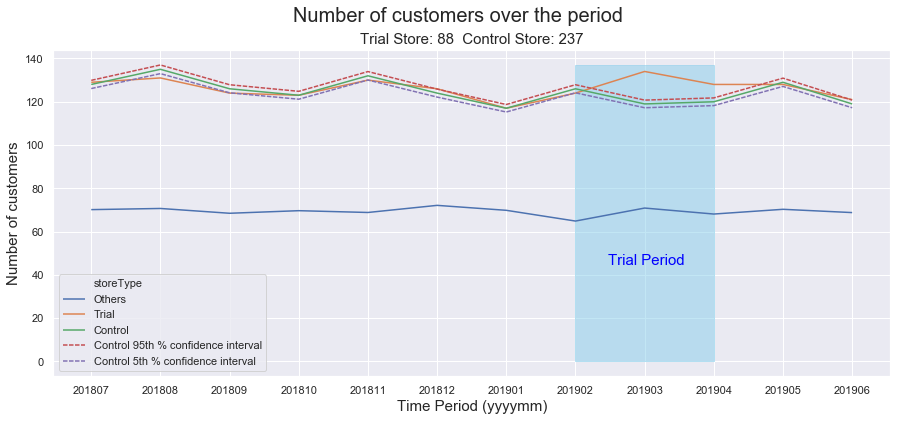

In [66]:
controlStoreViz(measureOverTime, controlStore=237, trialStore=88, stdDev=stdDev, on="nCustomers", savfig=True)

### Observation:

The results show that the trial in store 88 is **significantly different** to its control store in the trial period as the trial store performance **lies outside** the 5% and 95% confidence interval of the control store in **two of the three trial months.**

---
# Conclusion

#### First we found control stores for trial stores using pre-trial period data
- Control store 233 for trial store 77
- Control store 155 for trial store 86
- Control store 237 for trial store 88
    

#### Then we assessed trial store's performance in trial period
- We found there was a significant difference in the sales and number of customers for two out of three trial months for trial stores 77 and 88
    - Sales and number of customers increased for those months
    
    
- However, for trial store 86 there was no significant difference in the sales but there was significant difference in the number of customers
    - Number of customers were increased for all three trial months
    - Sales was inceasd for one out of three trial months


- This shows that, trial store 86 was able to attract significantly more customers in trial period than pre-trial period however, sales did not increased significantly. We need to check with the category manager, if some different startegy was applied at this store.


#### Overall, impact of the new trial layouts at trial stores shows a significant increase in sales.
---
 #### *We can tell the Category Manger that the trial layout was successful in creating an impact on sales, and therefore it can be rolled out to all their stores as well.*
---